# chapter 4: `ownership`
## 4.1 what is ownership?

In [2]:
{                      // s is not valid here, it’s not yet declared
    let s = "hello";   // s is valid from this point forward

    // do stuff with s
}                      // this scope is now over, and s is no longer valid

()

## the `String` type
the above example is a string literal, it is hardcoded. it has a fixed, known length and so it can be stored at the stack. however, sometimes we want to work with strings that are more flexible, that are mutable and perhaps not known at compile time (user input for example)

declaration

In [3]:
let s = String::from("hello");

mutation

In [4]:
let mut s = String::from("hello"); // requests

s.push_str(", world!"); // push_str() appends a literal to a String

println!("{}", s); // This will print `hello, world!`

hello, world!


With the String type, in order to support a mutable, growable piece of text, we need to allocate an amount of memory on the heap, unknown at compile time, to hold the contents. This means:
- The memory must be requested from the memory allocator at runtime.
- We need a way of returning this memory to the allocator when we’re done with our String.

The first part we do when we declare a variable, the second is handled as the variable goes "`out of scope`

In [6]:
{
    let s = String::from("hello"); // s is valid from this point forward

    // do stuff with s
} // rust calls internal drop function to free memory as this scope is now over, 
// and s is no longer valid

()

### examples

In [13]:
let x = 5; // bind x to 5, push to stack
let y = x; // bind y to x, which is 5, and push to stack

let x = 6; // y does not change as it's on the stack
y 

5

In [14]:
let s1 = String::from("hello");
let s2 = s1; // what's this?

#

representation of the s1 as stored on stack, it's just a `pointer` (to the actual obnject on the heap), the `length` of the object (in bytes) and it's `capacity` (memory allocated on the heap)

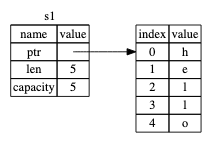

when we copy s2 to s1 we mean that s2 is the same (pointer, length, capacity)-tripple as s1. meaning that we do not actually copy the object, but the reference to the object. if the underlying object is changed, both references point to the modified object

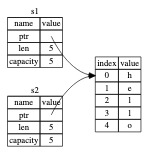

note that Rust does NOT copy the contents on the heap as well (which would be very expensive in terms of runtime performance), but only the reference

### double free error
as mentioned, when a variable goes out of scope Rust cleans up the corresponding part on the heap, so what happens if we create two references to an place on the heap?

In [15]:
let s1 = String::from("hello");
let s2 = s1;

println!("{}, world!", s1);

Error: borrow of moved value: `s1`

rust does not allow the above to happen to ensure memory safety as freeing up memory twice can lead to memory corruption; thus after s2 = s1 Rust considers s1 as no longer valid

In [18]:
let s1 = String::from("hello");
let s2 = s1.clone(); // copies to content on the heap as well! but more costly
s1

"hello"

## stack-only data: copy

In [19]:
let x = 5;
let y = x;

println!("x = {}, y = {}", x, y);

x = 5, y = 5


In [20]:
let x = 5;
{
    let y = x;
}
x

5

copies on the stack are cheap! there's no difference between deep and shallow copies here

## ownership and functions

In [25]:
drop(s) // deallocate memory because we use notebook which stores `s` from before

()

In [27]:
fn takes_ownership(some_string: String) { // some_string comes into scope
    println!("{}", some_string);
} // Here, some_string goes out of scope and `drop` is called. The backing
  // memory is freed.

fn makes_copy(some_integer: i32) { // some_integer comes into scope
    println!("{}", some_integer);
} // Here, some_integer goes out of scope. Nothing special happens.


{
    let s = String::from("hello");  // s comes into scope

    takes_ownership(s);             // s's value moves into the function...
                                    // ... and so is no longer valid here

    let x = 5;                      // x comes into scope

    makes_copy(x);                  // x would move into the function,
                                    // but i32 is Copy, so it's okay to still
                                    // use x afterward

} // Here, x goes out of scope, then s. But because s's value was moved, nothing
  // special happens.

hello
5


()

x is an i32 (stored on stack) so a copy of it is made in `makes_copy` and so x is stil available even after being passed into the function

In [30]:
x

5

only a copy of the reference was of s made in `takes_ownership` as s was stored on the heap and so s was moved into the functions scope and the memory corresponding to s was freed when going outside the function scope

In [31]:
s

Error: cannot find value `s` in this scope

In [32]:
fn gives_ownership() -> String {             // gives_ownership will move its
     // return value into the function
     // that calls it

let some_string = String::from("yours"); // some_string comes into scope

some_string                              // some_string is returned and
     // moves out to the calling
     // function
}

// This function takes a String and returns one
fn takes_and_gives_back(a_string: String) -> String { // a_string comes into
              // scope

a_string  // a_string is returned and moves out to the calling function
}

{
    let s1 = gives_ownership();         // gives_ownership moves its return
    // value into s1

    let s2 = String::from("hello");     // s2 comes into scope

    let s3 = takes_and_gives_back(s2);  // s2 is moved into
    // takes_and_gives_back, which also
    // moves its return value into s3
} // Here, s3 goes out of scope and is dropped. s2 was moved, so nothing
// happens. s1 goes out of scope and is dropped.

()

The ownership of a variable follows the same pattern every time: assigning a value to another variable moves it. When a variable that includes data on the heap goes out of scope, the value will be cleaned up by drop UNLESS ownership of the data has been moved to another variable.

However, if functions always took ownership of the inputs we would have to return them along with whatever else we wanted to function to return, which would be tedious, hence Rust has a feature for transferring ownership, called `references`.

## `references`
A `reference &` is like a pointer in that it’s an address we can follow to access the data stored at that address; that data is owned by some other variable. Unlike a pointer, a reference is guaranteed to point to a valid value of a particular type for the life of that reference.

In [33]:
fn calculate_length(s: &String) -> usize { // note the & before the input
    s.len()
}

let s1 = String::from("hello");
let len = calculate_length(&s1); // note the & before s1
println!("The length of '{}' is {}.", s1, len);

The length of 'hello' is 5.
